**Data preparation for Sentiment Analysis (SA)**

The goal is to create a proper reviews data file for further processing. 


In [1]:
spark

# Initial settings

In [2]:
%%bash
# pip3 install pandas numpy matplot seaborn

In [3]:
import os, sys

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# some Spark related imports we will use hereafter

from pyspark.sql import SparkSession 
import pyspark.sql.functions as F 
from pyspark.sql.types import *

In [5]:
# Create Spark session if we want to

spark = SparkSession.builder.appName("ResettingSentimentAnalysis").getOrCreate()

23/06/14 22:53:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Useful functions, namely visualization functions

In [6]:
def plotLine(df, xcol, ycol):
    return sns.lineplot(data=df, x=xcol, y=ycol)

def plotBar(df, xcol, ycol, huecol=None):
    return sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

def plotScatter(df, xcol, ycol, huecol=None):
    return sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

def plotScatterMatrix(df, huecol=None): 
    return sns.pairplot(data=df, hue=huecol)

# Data ingestion

In [7]:
filepath = 'data'

In [8]:
%%bash
ls -la data

total 328
drwxr-xr-x@ 16 adriano  staff    512 Jun 12 23:17 .
drwxr-xr-x  10 adriano  staff    320 Jun 14 22:52 ..
-rw-rw-r--@  1 adriano  staff  14421 Jun 14 12:36 Achlada.fin.2.csv
-rw-rw-r--@  1 adriano  staff   3885 Jun 14 12:37 FamilyHotelRelax.fin.csv
-rw-rw-r--@  1 adriano  staff   3717 Jun 14 12:39 FarmaSotira.fin.csv
-rw-rw-r--@  1 adriano  staff   4145 Jun 14 12:39 HotelElCami.fin.csv
-rw-rw-r--@  1 adriano  staff   4486 Jun 14 12:40 HotelJerry.fin.csv
-rw-rw-r--@  1 adriano  staff  16064 Jun 14 12:40 HotelManili.fin.csv
-rw-rw-r--@  1 adriano  staff   7213 Jun 14 12:40 LxRossio.fin.csv
-rw-rw-r--@  1 adriano  staff  19503 Jun 14 12:40 MonteDaProvenca.csv
-rw-rw-r--@  1 adriano  staff   5347 Jun 14 12:41 Senator.fin.csv
-rw-rw-r--@  1 adriano  staff   5975 Jun 14 12:41 SevenRoomsFlat.fin.csv
-rw-rw-r--@  1 adriano  staff   4443 Jun 14 12:41 StoneBeach.fin.csv
-rw-rw-r--@  1 adriano  staff  12314 Jun 14 12:36 aguadalma.fin.2.csv
-rw-rw-r--@  1 adriano  staff  13604 Jun 14 12:3

In [9]:
%%bash
for i in ./data/*
do
    echo ""
    echo "File: ${i}"
    head -n 2 "${i}"
    echo ""
    tail -n 1 "${i}"
    echo ""
done


File: ./data/Achlada.fin.2.csv
﻿ID;Source;Entity;Location;Country;Collection date;Review date;Review text
1683299003-58;https://www.tripadvisor.com/Hotel_Review-g14007852-d1058472-Reviews-Achlada_Mourtzanakis_Residence-Achlada_Crete.html#/media/1058472/111479167:p/?albumid=101&type=0&category=101;Mourtzanakis Residence;Achlada, Crete;Greece;05/05/2023;01/07/2022;If you are Looking for a magical vacation in nature ,with magic views of the  sea, mountains all around ,the ringing goats grazing in the meadow, and clear mountain air the…… ‏MourtzanakIs  Resort is the perfect place. ‏ It is a  calm and quiet place with a strong  presence of nature. ‏ The resort is located in an ancient village called Achlada which is about a half hour far  from Heraklion ‏ We had a small vacation unit which was quiet well equipped.  The staff was  polite and willing to help us in everything. Every request was fulfilled with a smile. ‏ The owner of the place, Marcus, is a  friendly and charming person,  with

In [10]:
# Read the data

schema = ( StructType()
          .add("ID",StringType(),True)
          .add("Source",StringType(),True)
          .add("Entity",StringType(),True)
          .add("Location",StringType(),True)
          .add("Country",StringType(),True)
          .add("Collection date",StringType(),True)
          .add("Review date",StringType(),True)
          .add("Review text",StringType(),True)
         )

df = spark.read.csv(filepath, header=True, schema=schema, sep=';')


In [11]:
# Check what has been read

df.printSchema()
reviews_count = df.count()
df.show()
reviews_count

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Collection date: string (nullable = true)
 |-- Review date: string (nullable = true)
 |-- Review text: string (nullable = true)

+--------------+--------------------+--------------------+----------------+-------+---------------+-----------+--------------------+
|            ID|              Source|              Entity|        Location|Country|Collection date|Review date|         Review text|
+--------------+--------------------+--------------------+----------------+-------+---------------+-----------+--------------------+
|1683301001-136|https://www.tripa...|Arolithos Traditi...|Heraklion, Crete| Greece|     05/05/2023| 01/10/2022|Amazing restful p...|
|1683301001-137|https://www.tripa...|Arolithos Traditi...|Heraklion, Crete| Greece|     05/05/2023| 01/10/2022|"We had lunch tod...|
|168330

201

# First clearance
Duplicates, overall nulls, get dates properly (datatypes) and to clean review text.

In [12]:
# Check duplicates

[reviews_count, df.dropDuplicates().count()]

[201, 201]

In [13]:
# Check counting with/without nulls

[reviews_count, df.dropna().count()]

[201, 201]

In [14]:
df = df.dropna()  # subset=['col name']

In [15]:
# Column names and datatypes
# .cast(DateType())
# F.to_date(...)

df = ( df
      .withColumn('Collection-date', F.to_date(F.col('Collection date'), "dd/MM/yyyy")) 
      .withColumn('Review-date', F.to_date(F.col('Review date'), "dd/MM/yyyy"))
     )

In [16]:
# Auxiliar UDF functions

CountWords = F.udf(lambda words: len(words), IntegerType())

# We should improve this cleaning text function

@F.udf(returnType=StringType()) 
def CleanText(text):
    regpat = re.compile(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b')
    filtered = []
    for w in text.split():
        wrd = w.strip().lower()
        for char in [',', '.', '?', '-']:
            wrd = wrd.replace(char, '')
        if not re.fullmatch(regpat, wrd) and wrd != ' ' and wrd != '' and '@' not in wrd:
            filtered.append(wrd)
    return ' '.join(filtered)


In [17]:
# Cleaning review text having in mind future sentiment analysis

df = ( df.withColumn('Review-clean-text', CleanText(F.col('Review text')))
          .withColumn('Review-clean-text-words-count', CountWords(F.col('Review-clean-text')))
     )

In [18]:
df.printSchema()
reviews_count = df.count()
df.show(1, vertical=True, truncate=False)
reviews_count

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Collection date: string (nullable = true)
 |-- Review date: string (nullable = true)
 |-- Review text: string (nullable = true)
 |-- Collection-date: date (nullable = true)
 |-- Review-date: date (nullable = true)
 |-- Review-clean-text: string (nullable = true)
 |-- Review-clean-text-words-count: integer (nullable = true)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 ID                            | 1683301001-136                                                                                                                                                                                             
 

201

# Data understanding - initial EDA

In [19]:
cols_to_forget = ['Collection date', 'Review date']
cols_interest = [x for x in df.columns if x not in cols_to_forget]
cols_interest

['ID',
 'Source',
 'Entity',
 'Location',
 'Country',
 'Review text',
 'Collection-date',
 'Review-date',
 'Review-clean-text',
 'Review-clean-text-words-count']

In [20]:
print('\nNulls:')
for cl in cols_interest:
    if cl not in ['Collection-date', 'Review-date']:
        k = df.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count() 
        if k > 0:
            print(f'Column {cl} with {k} nulls or NaN, out of {reviews_count} records ({k*100/reviews_count:.2f}%)')


Nulls:


In [21]:
print('\nUniqueness:') 
for cl in cols_interest:
    if cl not in ['Collection-date', 'Review-date']:
        k = df.select(cl).distinct().count()
        print(f'Column {cl} with {k} distinct values, out of {reviews_count} records ({k*100/reviews_count:.2f}%)')


Uniqueness:
Column ID with 201 distinct values, out of 201 records (100.00%)
Column Source with 23 distinct values, out of 201 records (11.44%)
Column Entity with 14 distinct values, out of 201 records (6.97%)
Column Location with 14 distinct values, out of 201 records (6.97%)
Column Country with 5 distinct values, out of 201 records (2.49%)
Column Review text with 201 distinct values, out of 201 records (100.00%)
Column Review-clean-text with 201 distinct values, out of 201 records (100.00%)
Column Review-clean-text-words-count with 156 distinct values, out of 201 records (77.61%)


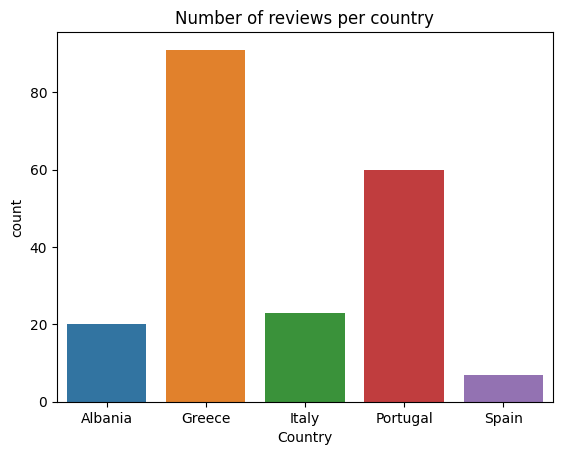

In [22]:
# How many reviews per country

df_plot = df.groupby('Country').count().sort('Country', ascending=True).toPandas()
plotBar(df_plot, 'Country', 'count')
plt.title('Number of reviews per country')
plt.show()

# Save the data of interest

In [23]:
cols_interest

['ID',
 'Source',
 'Entity',
 'Location',
 'Country',
 'Review text',
 'Collection-date',
 'Review-date',
 'Review-clean-text',
 'Review-clean-text-words-count']

In [24]:
# Save data as a parquet file

df.select(cols_interest).write.mode("overwrite").parquet("reviews")